In [1]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
from PIL import Image
import glob
import random
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import ToTensor, Resize
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms

<h1>Question 1</h1>

In [ ]:
df = pd.read_csv("../Assignment3/Grocery_Items_24.csv") 

In [ ]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# Assuming you have a DataFrame called 'df' with the transaction data

# Encode the data as binary values (0 or 1)
df_encoded = df.applymap(lambda x: 1 if x else 0)

# Perform Apriori algorithm with a minimum support of 0.01
frequent_itemsets = apriori(df_encoded, min_support=0.01, use_colnames=True)

# Generate association rules with a minimum confidence of 0.1
association_rules_df = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)

# Print the association rules
print(association_rules_df)


In [ ]:
import pandas as pd
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import seaborn as sns
import matplotlib.pyplot as plt

# Load your dataset into a Pandas DataFrame (assuming it's named 'df')

# Encode the data as binary values (0 or 1)
df_encoded = df.applymap(lambda x: 1 if x else 0)

# Specify the msv and mct values
msv_values = [0.001, 0.005, 0.01, 0.05]
mct_values = [0.05, 0.075, 0.1]

# Create an empty dictionary to store the count results
count_results = {}

# Iterate over the msv and mct values
for msv in msv_values:
    for mct in mct_values:
        # Perform Apriori algorithm with the current msv and mct
        frequent_itemsets = apriori(df_encoded, min_support=msv, use_colnames=True)
        association_rules_df = association_rules(frequent_itemsets, metric="confidence", min_threshold=mct)
        
        # Count the number of association rules
        count_results[(msv, mct)] = len(association_rules_df)

# Create a DataFrame from the count results
count_df = pd.DataFrame(count_results, index=[1])  # Set an arbitrary index, in this case, [1]
count_df.columns = mct_values

# Create a heatmap using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(count_df, annot=True, cmap="YlGnBu", fmt="g", cbar=True)
plt.xlabel("Minimum Confidence Threshold (mct)")
plt.ylabel("Minimum Support Value (msv)")
plt.title("Association Rule Counts Heatmap")
plt.show()


<h1>Question 2</h1>


In [2]:
def image_loader(path):
    img =  cv2.imread(path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = img.reshape(3,331,331)
    return img


In [3]:
# mapping labels to 0 to 3 for all the four classes
labmap = {0: "n02089078-black-and-tan_coonhound"
          ,1: "n02091831-Saluki"
          ,2:"n02092002-Scottish_deerhound"
          ,3:"n02095314-wire-haired_fox_terrier"} 

BATCH_SIZE = 16

data_set = dset.ImageFolder(root="../DataSet/ProcessedDatasets/",loader = image_loader) # should we add any transforms or split in



torch.Size([3, 331, 331])
<class 'torch.Tensor'>


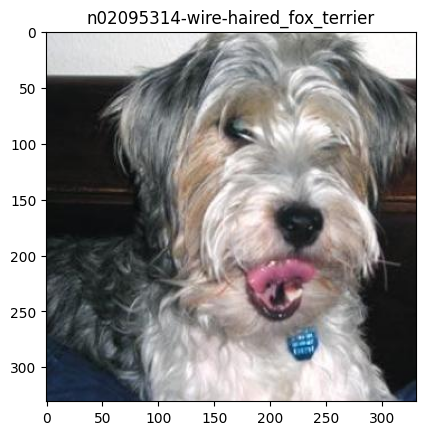

In [4]:
# for testing the data loader

train_set, val_set = random_split(data_set, [0.8, 0.2])
train_loader = DataLoader(dataset=train_set, shuffle=True, batch_size=BATCH_SIZE)

# Create DataLoader for validation set
val_loader = DataLoader(dataset=val_set, batch_size=BATCH_SIZE)
for img,label in train_loader:
    print(img[0].shape)
    plt.imshow(img[0].reshape(331,331,3))
    plt.title(labmap[int(label[0])])
    print(type(img[0]))
    break

In [5]:

class CNN(nn.Module):
    def __init__(self, kernel_size,dim = 164) -> None:
        super(CNN, self).__init__()
        self.Layer1 = nn.Conv2d(3, 8, kernel_size=kernel_size, bias=True)
        self.max_pool = nn.MaxPool2d(kernel_size=(2, 2))
        self.flatten = nn.Flatten()
        self.hidden = nn.Linear(8 * dim * dim, 16)
        self.fc = nn.Linear(16, 4)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.Layer1(x.float())
        x = self.relu(x)
        x = self.max_pool(x)
        x = self.flatten(x)
        x = self.hidden(x)
        x = self.relu(x)
        x = self.fc(x)
        return nn.functional.softmax(x)


In [6]:
model_kernel_3 = CNN(kernel_size=(3, 3),dim=164)
model_kernel_5 = CNN(kernel_size=(5, 5),dim=163)
model_kernel_7 = CNN(kernel_size=(7, 7),dim=162)


In [7]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    correct_predictions = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()

    average_loss = total_loss / len(dataloader.dataset)
    accuracy = correct_predictions / len(dataloader.dataset)

    return average_loss, accuracy

# Function to evaluate the model on the validation set
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct_predictions = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()

    average_loss = total_loss / len(dataloader.dataset)
    accuracy = correct_predictions / len(dataloader.dataset)

    return average_loss, accuracy

# Function to train the model for multiple epochs
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=20):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Train the model
        train_loss, train_accuracy = train_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Evaluate the model on the validation set
        
        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch + 1}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    # Plot the training and validation accuracies
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Modify the loss function and optimizer according to your problem
criterion = nn.CrossEntropyLoss()



C:\Users\kaasa\AppData\Local\Temp\ipykernel_1176\754776829.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.functional.softmax(x)


Epoch 1/20 | Train Loss: 0.0970, Train Acc: 0.2137 | Val Loss: 0.1026, Val Acc: 0.2013
Epoch 2/20 | Train Loss: 0.0970, Train Acc: 0.2154 | Val Loss: 0.1026, Val Acc: 0.2013
Epoch 3/20 | Train Loss: 0.0972, Train Acc: 0.2154 | Val Loss: 0.1026, Val Acc: 0.2013
Epoch 4/20 | Train Loss: 0.0970, Train Acc: 0.2154 | Val Loss: 0.1026, Val Acc: 0.2013
Epoch 5/20 | Train Loss: 0.0972, Train Acc: 0.2154 | Val Loss: 0.1026, Val Acc: 0.2013
Epoch 6/20 | Train Loss: 0.0970, Train Acc: 0.2154 | Val Loss: 0.1026, Val Acc: 0.2013
Epoch 7/20 | Train Loss: 0.0969, Train Acc: 0.2154 | Val Loss: 0.1026, Val Acc: 0.2013
Epoch 8/20 | Train Loss: 0.0970, Train Acc: 0.2154 | Val Loss: 0.1026, Val Acc: 0.2013
Epoch 9/20 | Train Loss: 0.0970, Train Acc: 0.2154 | Val Loss: 0.1026, Val Acc: 0.2013
Epoch 10/20 | Train Loss: 0.0968, Train Acc: 0.2154 | Val Loss: 0.1026, Val Acc: 0.2013
Epoch 11/20 | Train Loss: 0.0970, Train Acc: 0.2154 | Val Loss: 0.1026, Val Acc: 0.2013
Epoch 12/20 | Train Loss: 0.0970, Train A

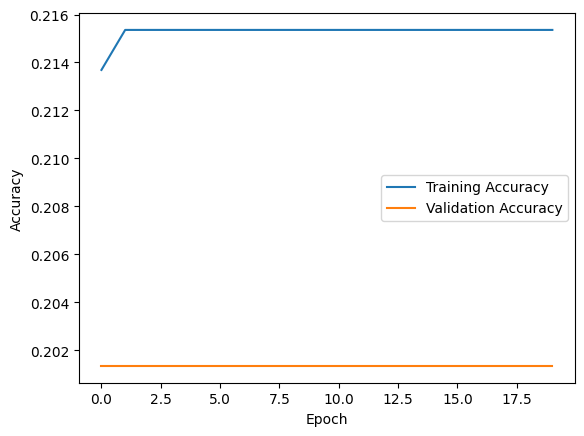

In [8]:
# Train the model
model_kernel_3.to(device)
optimizer = optim.Adam(model_kernel_3.parameters(), lr=4e-6)
train_model(model_kernel_3, train_loader, val_loader, criterion, optimizer, device, num_epochs=20)

C:\Users\kaasa\AppData\Local\Temp\ipykernel_1176\754776829.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.functional.softmax(x)


Epoch 1/20 | Train Loss: 0.0887, Train Acc: 0.3372 | Val Loss: 0.0929, Val Acc: 0.3356
Epoch 2/20 | Train Loss: 0.0832, Train Acc: 0.4124 | Val Loss: 0.0971, Val Acc: 0.2617
Epoch 3/20 | Train Loss: 0.0863, Train Acc: 0.3773 | Val Loss: 0.0897, Val Acc: 0.4228
Epoch 4/20 | Train Loss: 0.0832, Train Acc: 0.4190 | Val Loss: 0.0922, Val Acc: 0.3624
Epoch 5/20 | Train Loss: 0.0783, Train Acc: 0.5008 | Val Loss: 0.0891, Val Acc: 0.4027
Epoch 6/20 | Train Loss: 0.0796, Train Acc: 0.4808 | Val Loss: 0.0877, Val Acc: 0.4362
Epoch 7/20 | Train Loss: 0.0826, Train Acc: 0.4374 | Val Loss: 0.0913, Val Acc: 0.3893
Epoch 8/20 | Train Loss: 0.0794, Train Acc: 0.4791 | Val Loss: 0.0871, Val Acc: 0.4430
Epoch 9/20 | Train Loss: 0.0807, Train Acc: 0.4608 | Val Loss: 0.0867, Val Acc: 0.4564
Epoch 10/20 | Train Loss: 0.0756, Train Acc: 0.5442 | Val Loss: 0.0845, Val Acc: 0.5034
Epoch 11/20 | Train Loss: 0.0784, Train Acc: 0.4975 | Val Loss: 0.0898, Val Acc: 0.3960
Epoch 12/20 | Train Loss: 0.0750, Train A

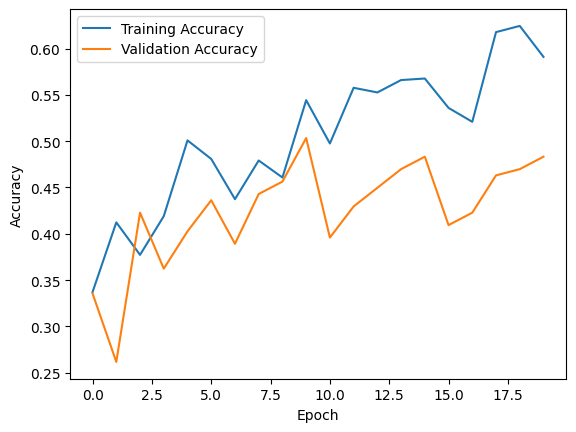

In [9]:
# Train the model
model_kernel_5.to(device)

optimizer = optim.Adam(model_kernel_5.parameters(), lr=4e-6)
train_model(model_kernel_5, train_loader, val_loader, criterion, optimizer, device, num_epochs=20)

C:\Users\kaasa\AppData\Local\Temp\ipykernel_1176\754776829.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.functional.softmax(x)


Epoch 1/20 | Train Loss: 0.0932, Train Acc: 0.2705 | Val Loss: 0.1010, Val Acc: 0.2416
Epoch 2/20 | Train Loss: 0.0932, Train Acc: 0.2738 | Val Loss: 0.1010, Val Acc: 0.2416
Epoch 3/20 | Train Loss: 0.0934, Train Acc: 0.2738 | Val Loss: 0.1010, Val Acc: 0.2416
Epoch 4/20 | Train Loss: 0.0935, Train Acc: 0.2721 | Val Loss: 0.1010, Val Acc: 0.2416
Epoch 5/20 | Train Loss: 0.0930, Train Acc: 0.2738 | Val Loss: 0.1010, Val Acc: 0.2416
Epoch 6/20 | Train Loss: 0.0935, Train Acc: 0.2738 | Val Loss: 0.1010, Val Acc: 0.2416
Epoch 7/20 | Train Loss: 0.0932, Train Acc: 0.2738 | Val Loss: 0.1010, Val Acc: 0.2416
Epoch 8/20 | Train Loss: 0.0932, Train Acc: 0.2738 | Val Loss: 0.1010, Val Acc: 0.2416
Epoch 9/20 | Train Loss: 0.0930, Train Acc: 0.2738 | Val Loss: 0.1010, Val Acc: 0.2416
Epoch 10/20 | Train Loss: 0.0935, Train Acc: 0.2738 | Val Loss: 0.1010, Val Acc: 0.2416
Epoch 11/20 | Train Loss: 0.0930, Train Acc: 0.2738 | Val Loss: 0.1010, Val Acc: 0.2416
Epoch 12/20 | Train Loss: 0.0934, Train A

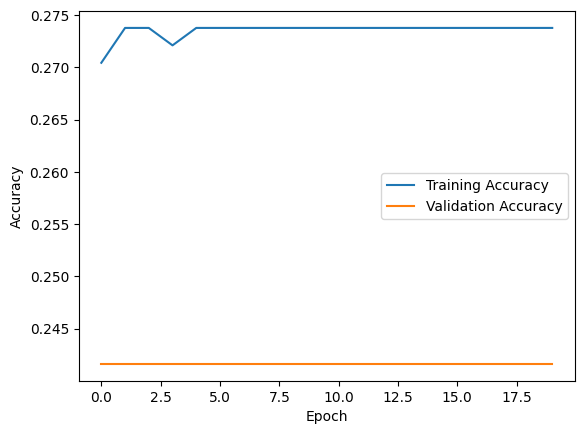

In [10]:
# Train the model

model_kernel_7 .to(device)

optimizer = optim.Adam(model_kernel_7.parameters(), lr=4e-6)
train_model(model_kernel_7, train_loader, val_loader, criterion, optimizer, device, num_epochs=20)